<a href="https://colab.research.google.com/github/LonelyFort/pytorch_deeplearning_exercises/blob/main/extras/exercises/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [ ]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data/pizza_steak_sushi directory exists.


### Prepare data

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f923a9c6750>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [ ]:
# Setup the model with pretrained weights and send it to the target device
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 8.543 seconds


### Make predictions on the entire test dataset with the model

In [ ]:
from tqdm.auto import tqdm

test_preds = []
model_0.eval()

with torch.inference_mode():

  for X, y in tqdm(test_dataloader):

    X, y = X.to(device), y.to(device)

    # Make predictions
    y_pred = model_0(X)

    # Turn into pred probs
    y_pred_probs = torch.softmax(y_pred, dim=1)

    # Turn into pred labels
    y_pred_labels = torch.argmax(y_pred_probs, dim=1)

    # Append to list
    test_preds.append(y_pred_labels)

test_preds = torch.cat(test_preds).cpu()
test_preds


  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [ ]:
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.24.0


In [ ]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.24.0


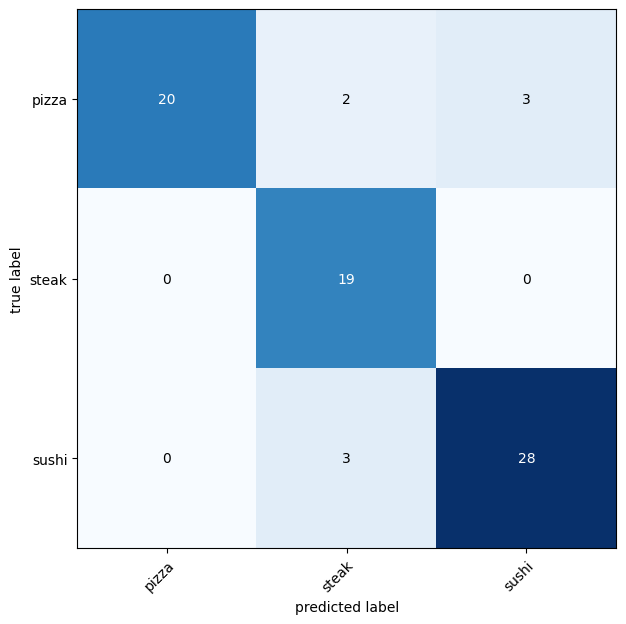

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

confmat_tensor

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names,
                                figsize=(10, 7))

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [ ]:
# Get all test data paths
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

from PIL import Image
def pred_and_plot(test_paths, model, transform, device, class_names) :
  test_pred_list = []

  for path in tqdm(test_paths):
    pred_dict = {}

    # get sample path
    pred_dict['image_path'] = path

    # get class names
    class_name = path.parent.stem
    pred_dict['class_name'] = class_name

    # get image
    img = Image.open(path)
    transformed_image = transform(img).unsqueeze(0).to(device)

    # get prediction
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      pred_dict['pred_class'] = pred_class
      pred_dict['pred_prob'] = pred_prob.max().cpu().item()

    pred_dict["correct"] = class_name == pred_class

    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dict = pred_and_plot(test_data_paths,
                               model_0,
                               simple_transform,
                               device,
                               class_names)

test_pred_dict[:5]



  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/steak/354513.jpg'),
  'class_name': 'steak',
  'pred_class': 'steak',
  'pred_prob': 0.5341949462890625,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/1302563.jpg'),
  'class_name': 'steak',
  'pred_class': 'steak',
  'pred_prob': 0.8452677726745605,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg'),
  'class_name': 'steak',
  'pred_class': 'steak',
  'pred_prob': 0.7824719548225403,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
  'class_name': 'steak',
  'pred_class': 'steak',
  'pred_prob': 0.46011871099472046,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
  'class_name': 'steak',
  'pred_class': 'steak',
  'pred_prob': 0.7858447432518005,
  'correct': True}]

In [ ]:
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dict)

# get 5 most wrong
top_5_most_wrong = test_pred_df[test_pred_df['correct'] == False].sort_values(by=['pred_prob'], ascending=False).head(5)
top_5_most_wrong

,image_path,class_name,pred_class,pred_prob,correct
21,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,steak,0.546966,False
35,data/pizza_steak_sushi/test/sushi/1172255.jpg,sushi,steak,0.449595,False
65,data/pizza_steak_sushi/test/pizza/971934.jpg,pizza,sushi,0.444701,False
72,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,sushi,0.435138,False
51,data/pizza_steak_sushi/test/pizza/309892.jpg,pizza,sushi,0.426874,False


/tmp/ipython-input-4150143823.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = row[0]
/tmp/ipython-input-4150143823.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = row[1]
/tmp/ipython-input-4150143823.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_prob = row[2]
/tmp/ipython-input-4150143823.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version

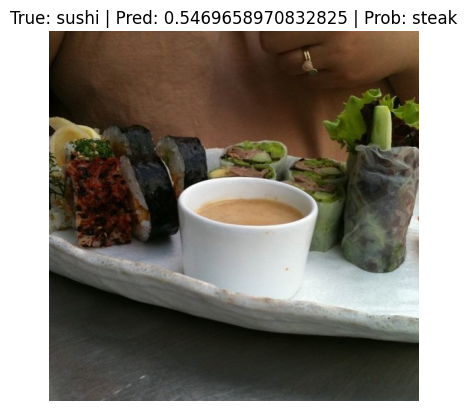

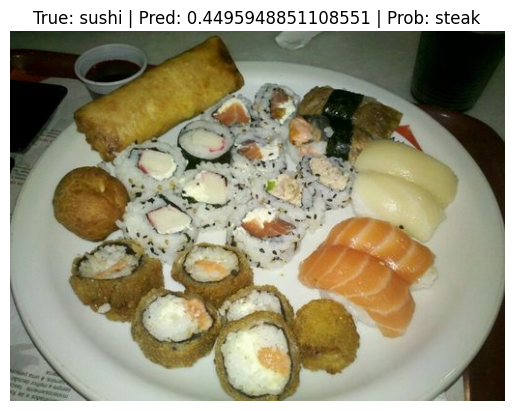

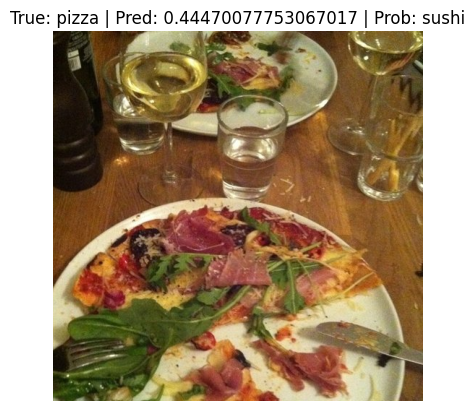

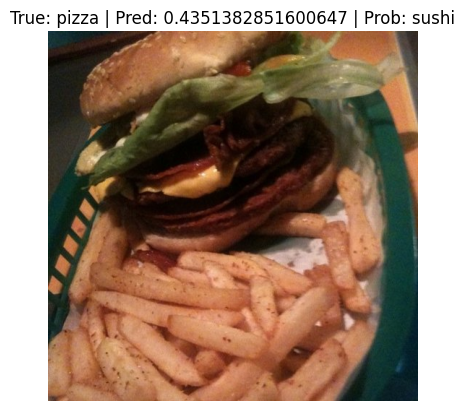

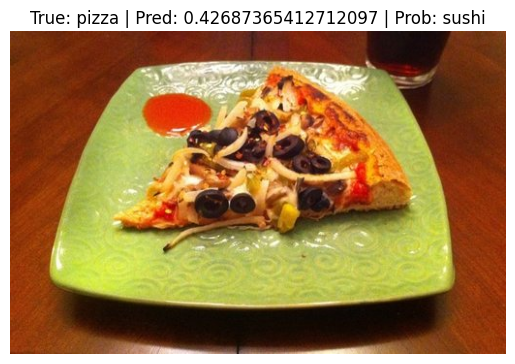

In [ ]:
import torchvision
import matplotlib.pyplot as plt

for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]

  img = torchvision.io.read_image(str(image_path)) # get image as tensor
  plt.figure()
  plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in [height, width, color_channels]
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob}")
  plt.axis(False);

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [ ]:
# TODO: Get an image of pizza/steak/sushi
!wget https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
!cp photo-1588315029754-2dd089d39a1a pizza.jpg

from PIL import Image

with Image.open('pizza.jpg') as img:
  img.show()

--2025-12-20 11:14:12--  https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3208960 (3.1M) [image/jpeg]
Saving to: ‘photo-1588315029754-2dd089d39a1a.1’

photo-1588315029754 100%[===================>]   3.06M  --.-KB/s    in 0.04s   

2025-12-20 11:14:13 (74.1 MB/s) - ‘photo-1588315029754-2dd089d39a1a.1’ saved [3208960/3208960]



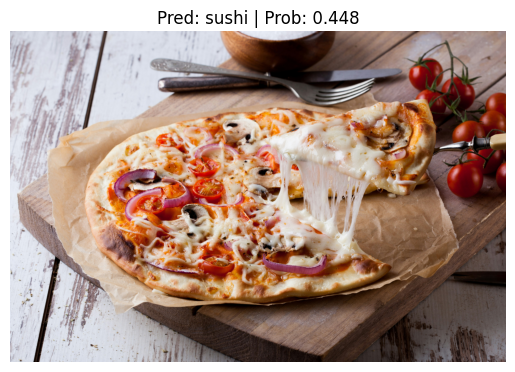

In [ ]:
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):

  image = Image.open(image_path)

  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])

  model.to(device)

  model.eval()

  with torch.inference_mode():
    transformed_image = image_transform(image).unsqueeze(dim=0)

    target_image_pred = model(transformed_image.to(device))

  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  plt.figure()
  plt.imshow(image)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);

pred_and_plot_image(model=model_0, image_path='pizza.jpg', class_names=class_names, transform=simple_transform)

In [ ]:
# TODO: Get an image of not pizza/steak/sushi
!wget https://media.glamour.com/photos/57b637cb3cb27ca97a4e02f3/master/w_2560%2Cc_limit/GettyImages-488226322.jpg
!cp GettyImages-488226322.jpg djt.jpg

--2025-12-20 11:14:25--  https://media.glamour.com/photos/57b637cb3cb27ca97a4e02f3/master/w_2560%2Cc_limit/GettyImages-488226322.jpg
Resolving media.glamour.com (media.glamour.com)... 13.249.126.111, 13.249.126.24, 13.249.126.48, ...
Connecting to media.glamour.com (media.glamour.com)|13.249.126.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 318532 (311K) [image/jpeg]
Saving to: ‘GettyImages-488226322.jpg.1’

GettyImages-4882263 100%[===================>] 311.07K  --.-KB/s    in 0.02s   

2025-12-20 11:14:25 (13.3 MB/s) - ‘GettyImages-488226322.jpg.1’ saved [318532/318532]



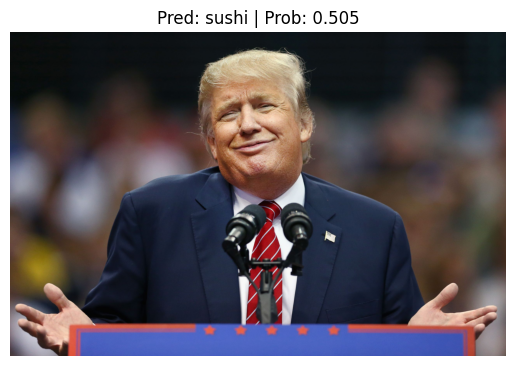

In [ ]:
pred_and_plot_image(model=model_0, image_path='djt.jpg', class_names=class_names, transform=simple_transform)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [ ]:
# TODO: Recreate a new model
model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
print(model_1.classifier)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_1.features.parameters():
    param.requires_grad = False

model_1.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

from going_modular import going_modular

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1096 | train_acc: 0.3359 | test_loss: 0.9031 | test_acc: 0.6818
Epoch: 2 | train_loss: 0.8836 | train_acc: 0.6602 | test_loss: 0.8116 | test_acc: 0.7642
Epoch: 3 | train_loss: 0.7831 | train_acc: 0.7852 | test_loss: 0.7364 | test_acc: 0.7434
Epoch: 4 | train_loss: 0.7482 | train_acc: 0.7305 | test_loss: 0.6446 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.6433 | train_acc: 0.7930 | test_loss: 0.6174 | test_acc: 0.8352
Epoch: 6 | train_loss: 0.5759 | train_acc: 0.7969 | test_loss: 0.5654 | test_acc: 0.8873
Epoch: 7 | train_loss: 0.5194 | train_acc: 0.9258 | test_loss: 0.5323 | test_acc: 0.8873
Epoch: 8 | train_loss: 0.5441 | train_acc: 0.7852 | test_loss: 0.5307 | test_acc: 0.8665
Epoch: 9 | train_loss: 0.5603 | train_acc: 0.7891 | test_loss: 0.4991 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.5005 | train_acc: 0.8164 | test_loss: 0.4166 | test_acc: 0.8958
[INFO] Total training time: 17.723 seconds


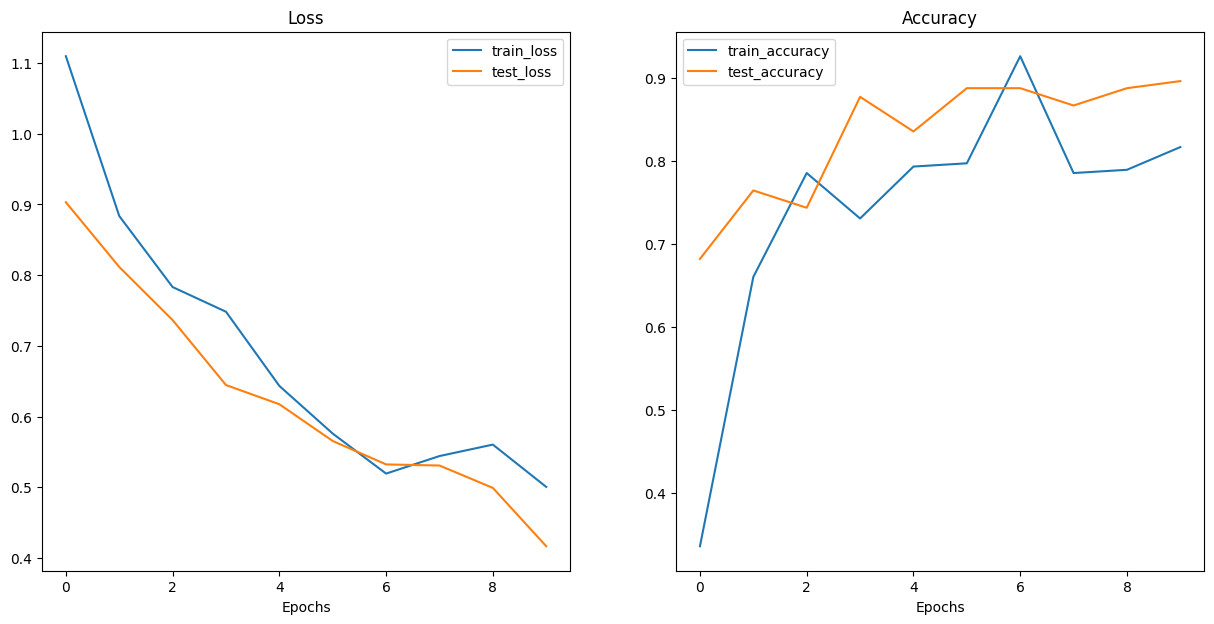

In [ ]:
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(model_1_results)

In [ ]:
# TODO: Train the model for 10 epochs
model_2 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_2.features.parameters():
    param.requires_grad = False

model_2.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_2_results = engine.train(model=model_2,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0295 | train_acc: 0.4688 | test_loss: 0.8933 | test_acc: 0.6515
Epoch: 2 | train_loss: 0.8559 | train_acc: 0.6289 | test_loss: 0.7036 | test_acc: 0.8343
Epoch: 3 | train_loss: 0.7716 | train_acc: 0.6758 | test_loss: 0.7053 | test_acc: 0.7841
Epoch: 4 | train_loss: 0.6592 | train_acc: 0.7578 | test_loss: 0.5981 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5984 | train_acc: 0.8789 | test_loss: 0.6026 | test_acc: 0.8655
Epoch: 6 | train_loss: 0.5942 | train_acc: 0.7695 | test_loss: 0.6148 | test_acc: 0.8456
Epoch: 7 | train_loss: 0.5070 | train_acc: 0.8086 | test_loss: 0.5058 | test_acc: 0.8864
Epoch: 8 | train_loss: 0.5208 | train_acc: 0.8125 | test_loss: 0.5256 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.5234 | train_acc: 0.8047 | test_loss: 0.4637 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.5081 | train_acc: 0.8125 | test_loss: 0.4591 | test_acc: 0.9280
Epoch: 11 | train_loss: 0.4313 | train_acc: 0.9727 | test_loss: 0.4737 | test_acc: 0.9176
Epoch: 12 | train_l

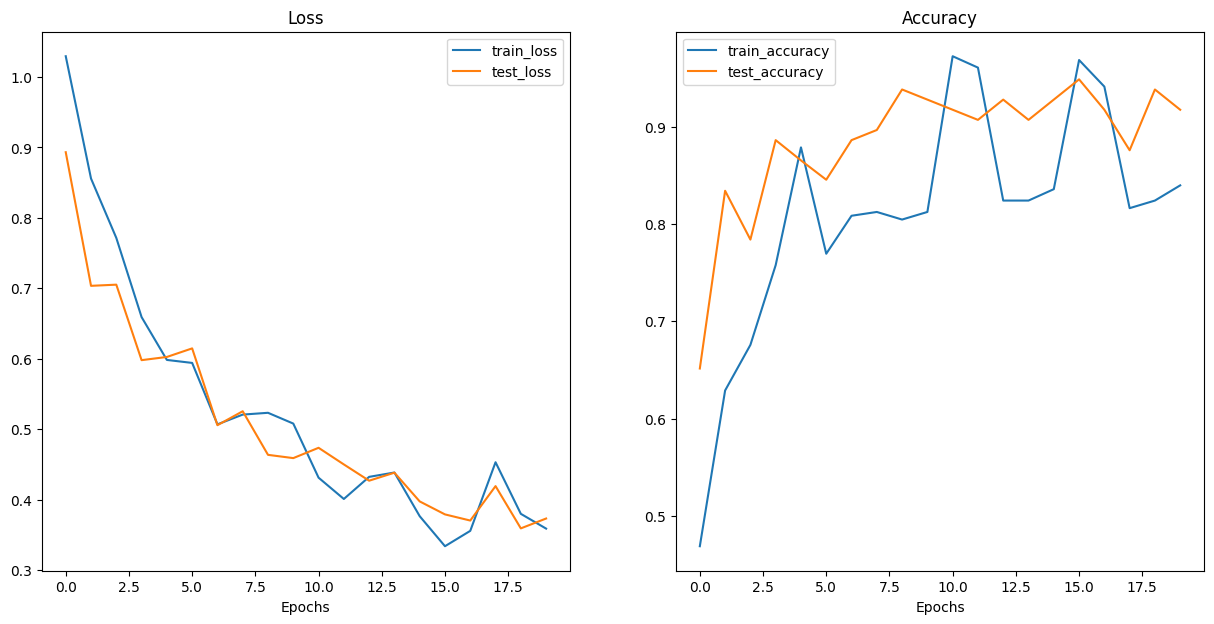

In [ ]:
plot_loss_curves(model_2_results)

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

data/pizza_steak_sushi_20_percent directory exists.


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f923ee6fd40>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [ ]:
model_3 = torchvision.models.convnext_tiny(weights="IMAGENET1K_V1").to(device)
print(model_3.classifier)

for param in model_3.features.parameters():
  param.requires_grad = False

model_3.classifier[2] = nn.Linear(in_features=768,
                                   out_features=len(class_names),
                                   bias=True).to(device)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 164MB/s] 


Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=1000, bias=True)
)


### Train a model with 20% of the data

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_3_results = engine.train(model=model_3,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1168 | train_acc: 0.9521 | test_loss: 0.0562 | test_acc: 0.9847
Epoch: 2 | train_loss: 0.0584 | train_acc: 0.9938 | test_loss: 0.0584 | test_acc: 0.9847
Epoch: 3 | train_loss: 0.0610 | train_acc: 0.9875 | test_loss: 0.0497 | test_acc: 0.9847
Epoch: 4 | train_loss: 0.0429 | train_acc: 0.9979 | test_loss: 0.0447 | test_acc: 0.9847
Epoch: 5 | train_loss: 0.0427 | train_acc: 0.9917 | test_loss: 0.0473 | test_acc: 0.9847
Epoch: 6 | train_loss: 0.0577 | train_acc: 0.9958 | test_loss: 0.0416 | test_acc: 0.9938
Epoch: 7 | train_loss: 0.0342 | train_acc: 0.9979 | test_loss: 0.0382 | test_acc: 0.9938
Epoch: 8 | train_loss: 0.0286 | train_acc: 1.0000 | test_loss: 0.0391 | test_acc: 0.9847
Epoch: 9 | train_loss: 0.0322 | train_acc: 0.9979 | test_loss: 0.0370 | test_acc: 0.9847
Epoch: 10 | train_loss: 0.0231 | train_acc: 1.0000 | test_loss: 0.0335 | test_acc: 0.9938
[INFO] Total training time: 37.607 seconds


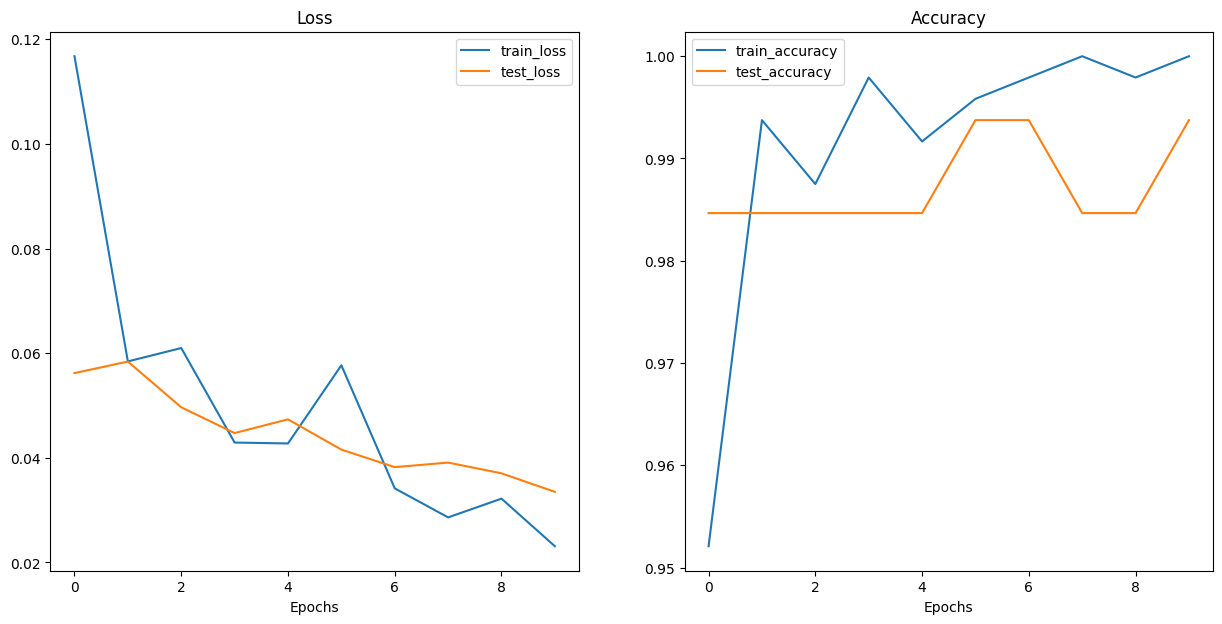

In [ ]:
plot_loss_curves(model_3_results)

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [ ]:
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])

(0.8967803030303031, 0.6243551969528198)

In [ ]:
max(model_1_results["test_acc"]), min(model_1_results["test_loss"])

(0.8958333333333334, 0.41663843393325806)

In [ ]:
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(0.9488636363636364, 0.35931187868118286)

In [ ]:
max(model_3_results["test_acc"]), min(model_3_results["test_loss"])

(0.99375, 0.03348466482711956)